# Convolutional autoencoders and LSTMs for PDE surrogates

The next set of lines are for importing common libraries utilized in this experiment

In [1]:
import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Loading SWE snapshot data for training/testing/validation

In [2]:
# Load data
data = np.load('../Equation_Based/snapshot_matrix_pod.npy').T

# Scale the training data to zero mean and unit standard deviation
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Transpose (rows are DOF, columns are snapshots)
data = data.T

# Make sure the data is in the right format (with channels as the last dimension)
swe_train_data = np.zeros(shape=(np.shape(data)[1],64,64,3))
for i in range(np.shape(data)[1]):
    temp_1 = data[0:64*64,i].reshape(64,64)
    temp_2 = data[64*64:2*64*64,i].reshape(64,64)
    temp_3 = data[2*64*64:3*64*64,i].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    

# Perform somthing similar (but for the test data)
data = np.load('../Equation_Based/snapshot_matrix_test.npy').T
data = scaler.transform(data)
# Transpose (rows are DOF, columns are snapshots)
data = data.T

# Make sure the data is in the right format (with channels as the last dimension)
swe_test_data = np.zeros(shape=(np.shape(data)[1],64,64,3)) # Channels last
for i in range(np.shape(data)[1]):
    temp_1 = data[0:64*64,i].reshape(64,64)
    temp_2 = data[64*64:2*64*64,i].reshape(64,64)
    temp_3 = data[2*64*64:3*64*64,i].reshape(64,64)
    swe_test_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_test_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_test_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
# Define rescaling function - useful later
def unscale(dataset,scaler):
    '''
    Input is scaled data in CNN compatible form
    '''
    dataset_phys = np.zeros_like(dataset)
    for i in range(dataset_phys.shape[0]):    
        temp_1 = dataset[i,:,:,0].T
        temp_2 = dataset[i,:,:,1].T
        temp_3 = dataset[i,:,:,2].T

        temp = np.concatenate((temp_1,temp_2,temp_3),axis=0).reshape(1,-1)
        temp = scaler.inverse_transform(temp)

        dataset_phys[i,:,:,0] = temp[0,:64*64].T.reshape(64,64)
        dataset_phys[i,:,:,1] = temp[0,64*64:2*64*64].T.reshape(64,64)
        dataset_phys[i,:,:,2] = temp[0,2*64*64:].T.reshape(64,64)
        
    return dataset_phys

In [3]:
# Randomize the data set (aids in training)
idx =  np.arange(swe_train_data.shape[0])
np.random.shuffle(idx)
swe_train_data_randomized = swe_train_data[idx[:]]

### Visualize snapshots

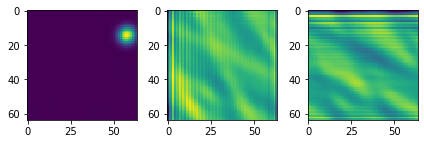

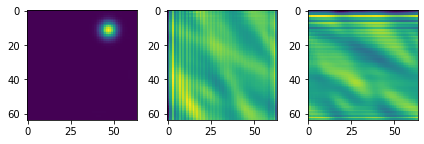

In [22]:
# Visualize one time instance of training
time = 0
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_train_data[time,:,:,0])
ax[1].imshow(swe_train_data[time,:,:,1])
ax[2].imshow(swe_train_data[time,:,:,2])
plt.tight_layout()
plt.show()

# Visualize one time instance of testing
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_test_data[time,:,:,0])
ax[1].imshow(swe_test_data[time,:,:,1])
ax[2].imshow(swe_test_data[time,:,:,2])
plt.tight_layout()
plt.show()

### Some global variables

In [23]:
 # The window size of the LSTM - this is the historical context used for making a prediction at a future timestep
time_window = 10
# Either 'train' or 'test', the latter uses the weights saved in this repository
mode = 'test' 

### Network hyperparameters

In [6]:
lrate = 3e-4 # Learning rate of the CNN
num_latent = 6 # Number of latent space dimensions in the autoencoder

### Convolutional autoencoder

In [24]:
# Custom activation function (Swish)
def my_swish(x, beta=1.0):
    return x * K.sigmoid(beta * x)

In [8]:
# Define model architecture
weights_filepath = 'best_weights_cae.h5'
## Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')

x = Conv2D(30,kernel_size=(3,3),activation=my_swish,padding='same')(encoder_inputs) # Convolve
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x) # Downsample

x = Conv2D(25,kernel_size=(3,3),activation=my_swish,padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation=my_swish,padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation=my_swish,padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation=my_swish,padding='same')(enc_l5)
x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Flatten()(x) # Flatten to 1D vector
x = Dense(50, activation=my_swish)(x) # Some more nonlinear transformations
x = Dense(25, activation=my_swish)(x)
x = Dense(10, activation=my_swish)(x)
encoded = Dense(num_latent)(x)
encoder = Model(inputs=encoder_inputs,outputs=encoded)
    
## Decoder
decoder_inputs = Input(shape=(num_latent,),name='decoded')
x = Dense(10,activation=my_swish)(decoder_inputs)
x = Dense(25,activation=my_swish)(x)
x = Dense(50,activation=my_swish)(x)
x = Dense(2*2*3,activation=my_swish)(x)

x = Reshape(target_shape=(2,2,3))(x)

x = Conv2D(10,kernel_size=(3,3),activation=my_swish,padding='same')(x) # Convolve
dec_l1 = UpSampling2D(size=(2, 2))(x) # Upsample

x = Conv2D(15,kernel_size=(3,3),activation=my_swish,padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation=my_swish,padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25,kernel_size=(3,3),activation=my_swish,padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation=my_swish,padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation='linear',padding='same')(dec_l5)
    
decoder = Model(inputs=decoder_inputs,outputs=decoded)

## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))
  
model = Model(inputs=encoder_inputs,outputs=ae_outputs,name='CAE')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Save the weights only if the validation loss reduces from previous best
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)

# Use an earlystopping criterion for preventing overfitting on training data
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,earlystopping]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error')# Use a simple L-2 norm for training the autoencoder
model.summary()

num_epochs = 5000
batch_size = 24

if mode == 'train':
    train_history = model.fit(x=swe_train_data_randomized, 
                              y=swe_train_data_randomized, 
                              epochs=num_epochs, batch_size=batch_size, 
                              callbacks=callbacks_list, validation_split=0.1)
    
    model.load_weights(weights_filepath)
else:
    model.load_weights(weights_filepath)

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Field (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Model)                (None, 6)                 19861     
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         18740     
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


### Check sample reconstruction

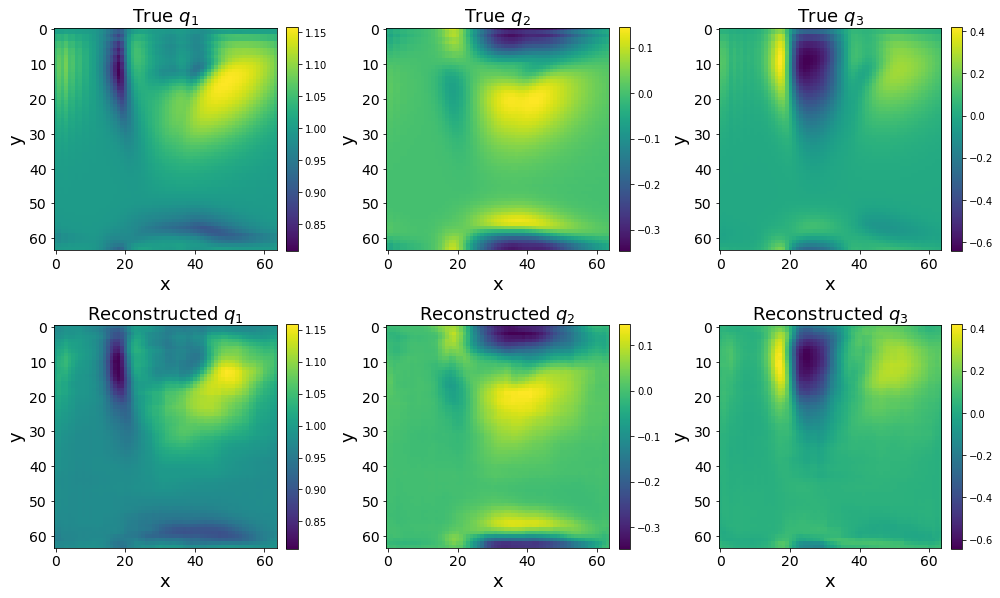

In [9]:
time = 10
true_field = unscale(swe_test_data[time:time+1],scaler)
pred_field = unscale(model.predict(swe_test_data[time:time+1,:,:,:]),scaler)

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(true_field[0,:,:,0],label='input')
ax[1,0].imshow(pred_field[0,:,:,0],label='decoded')

cs2 = ax[0,1].imshow(true_field[0,:,:,1],label='input')
ax[1,1].imshow(pred_field[0,:,:,1],label='decoded')

cs3 = ax[0,2].imshow(true_field[0,:,:,2],label='input')
ax[1,2].imshow(pred_field[0,:,:,2],label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x',fontsize=18)
        ax[i,j].set_ylabel('y',fontsize=18)
        ax[i,j].tick_params(labelsize=14)      
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$',fontsize=18)
ax[0,1].set_title(r'True $q_2$',fontsize=18)
ax[0,2].set_title(r'True $q_3$',fontsize=18)

ax[1,0].set_title(r'Reconstructed $q_1$',fontsize=18)
ax[1,1].set_title(r'Reconstructed $q_2$',fontsize=18)
ax[1,2].set_title(r'Reconstructed $q_3$',fontsize=18)

plt.subplots_adjust(wspace=0.5,hspace=-0.7)
plt.tight_layout()
plt.savefig('SWE_Reconstruction_Test.png')
plt.show()

### Generate encoded data for LSTM learning

In [10]:
encoded_list = []
for i in range(90):
    encoded_list.append(K.eval(encoder(swe_train_data[100*i:100*(i+1),:,:,:].astype('float32'))))

encoded = np.asarray(encoded_list)

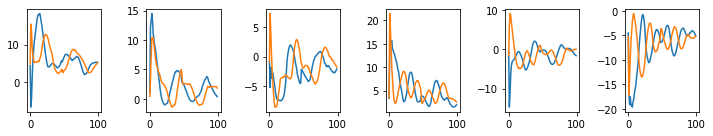

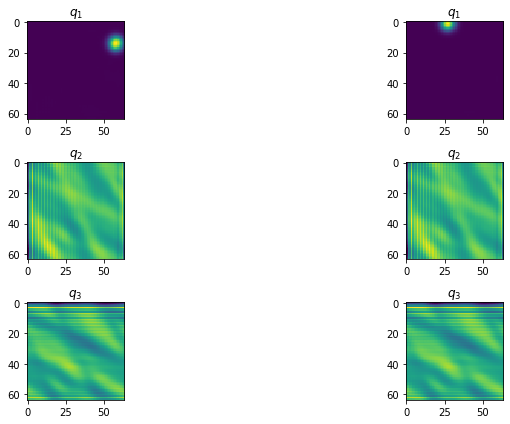

In [11]:
sim_num_1 = 0
sim_num_2 = 30
time = 0

fig, ax = plt.subplots(nrows=1,ncols=num_latent,figsize=(10,2))
ax[0].plot(encoded[sim_num_1,:,0])
ax[0].plot(encoded[sim_num_2,:,0])


ax[1].plot(encoded[sim_num_1,:,1])
ax[1].plot(encoded[sim_num_2,:,1])

ax[2].plot(encoded[sim_num_1,:,2])
ax[2].plot(encoded[sim_num_2,:,2])

ax[3].plot(encoded[sim_num_1,:,3])
ax[3].plot(encoded[sim_num_2,:,3])

ax[4].plot(encoded[sim_num_1,:,4])
ax[4].plot(encoded[sim_num_2,:,4])

ax[5].plot(encoded[sim_num_1,:,5])
ax[5].plot(encoded[sim_num_2,:,5])


plt.tight_layout()
plt.show()

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(14,6))

ax[0,0].imshow(swe_train_data[sim_num_1*100+time,:,:,0])
ax[0,0].set_title('$q_1$')

ax[1,0].imshow(swe_train_data[sim_num_1*100+time,:,:,1])
ax[1,0].set_title('$q_2$')

ax[2,0].imshow(swe_train_data[sim_num_1*100+time,:,:,2])
ax[2,0].set_title('$q_3$')


ax[0,1].imshow(swe_train_data[sim_num_2*100+time,:,:,0])
ax[0,1].set_title('$q_1$')

ax[1,1].imshow(swe_train_data[sim_num_2*100+time,:,:,1])
ax[1,1].set_title('$q_2$')

ax[2,1].imshow(swe_train_data[sim_num_2*100+time,:,:,2])
ax[2,1].set_title('$q_3$')

plt.tight_layout()
plt.show()

### Add parameter information

In [12]:
# Add parameter information
parameters = np.load('../Equation_Based/Locations.npy')
parameters_train = parameters[:90]
parameters_test = parameters[90:]

### Train LSTM

In [13]:
# encoded_scaled = encoded.reshape(90*100,4)
# lstm_scaler = MinMaxScaler()
# encoded_scaled = lstm_scaler.fit_transform(encoded_scaled).reshape(90,100,4)
# lstm_training_data = np.copy(encoded_scaled)

In [14]:
lstm_training_data = np.copy(encoded)
num_train_snapshots = 90
total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(total_size-time_window*num_train_snapshots,time_window,num_latent+2))
output_seq = np.zeros(shape=(total_size-time_window*num_train_snapshots,num_latent))

# Setting up inputs (window in, single timestep out)
sample = 0
for snapshot in range(num_train_snapshots):
    lstm_snapshot = lstm_training_data[snapshot,:,:]
    for t in range(time_window,100):
        input_seq[sample,:,:num_latent] = lstm_snapshot[t-time_window:t,:]
        input_seq[sample,:,num_latent:] = parameters_train[snapshot,:]
        output_seq[sample,:] = lstm_snapshot[t,:]
        sample = sample + 1

In [15]:
# Explicitly adding parameter information to the encoded data for parameteric ROM
parameter_info = np.zeros(shape=(90,100,2),dtype='double')
# Setting up inputs
sample = 0
for snapshot in range(num_train_snapshots):
    parameter_info[snapshot,:,:] = parameters_train[snapshot,:]
        
total_training_data = np.concatenate((lstm_training_data,parameter_info),axis=-1)

In [16]:
# Model architecture
lstm_model = models.Sequential()
lstm_model.add(LSTM(50,input_shape=(time_window, num_latent+2),return_sequences=True)) # One LSTM cell
lstm_model.add(LSTM(50,input_shape=(time_window, num_latent+2),return_sequences=True)) # One LSTM cell
lstm_model.add(LSTM(50,input_shape=(time_window, num_latent+2),return_sequences=False))  # One LSTM cell
lstm_model.add(Dense(num_latent, activation=None))

# training parameters
num_epochs = 500
batch_size = 24

# design network
lstm_filepath = 'lstm_weights.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Save the weights only if the validation loss reduces from previous best
checkpoint = ModelCheckpoint(lstm_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)

# Use an earlystopping criterion for preventing overfitting on training data
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint,earlystopping]

# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error')

In [ ]:
if mode == 'train':
    lstm_train_history = lstm_model.fit(input_seq, output_seq, 
                                        epochs=num_epochs, batch_size=batch_size, 
                                        callbacks=lstm_callbacks_list, validation_split=0.1)

### Test LSTM with parameter information

In [17]:
import time

In [18]:
lstm_model.load_weights(lstm_filepath)
encoded_list = []
for i in range(10):
    encoded_list.append(K.eval(encoder(swe_test_data[100*i:100*(i+1),:,:,:].astype('float32'))))
    
test_encoded = np.asarray(encoded_list)

In [19]:
lstm_testing_data = np.copy(test_encoded)

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,num_latent+2))
output_seq_pred = np.zeros(shape=(10,100,num_latent))

start_time = time.time()

for sim_num in range(10):
    # Setting up inputs
    sample = 0
    input_seq[0,:,:-2] = lstm_testing_data[sim_num,0:time_window,:]
    input_seq[0,:,-2] = parameters_test[sim_num,0]
    input_seq[0,:,-1] = parameters_test[sim_num,1]

    output_seq_pred[sim_num,:time_window,:] = lstm_testing_data[sim_num,:time_window,:]

    for t in range(time_window,100):
        output_seq_pred[sim_num,t,:] = lstm_model.predict(input_seq[0:1,:,:])[0,:]
        input_seq[0,0:time_window-1,:-2] = input_seq[0,1:,:-2] 
        input_seq[0,time_window-1,:-2] = output_seq_pred[sim_num,t,:]
        
end_time = time.time()
print('Average time per simulation:',(end_time-start_time)/10.0)

Average time per simulation: 1.8034260511398315


### Check quality in latent space for testing data

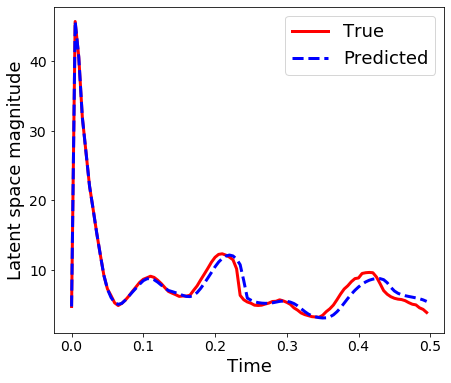

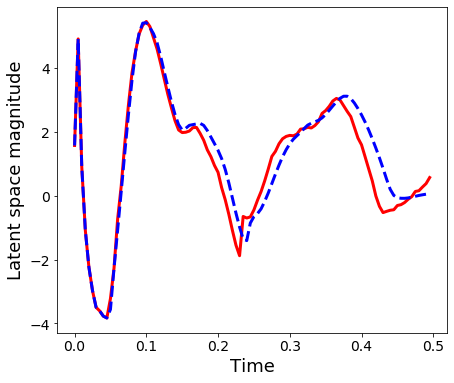

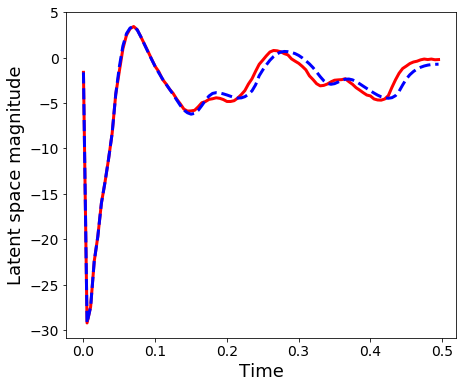

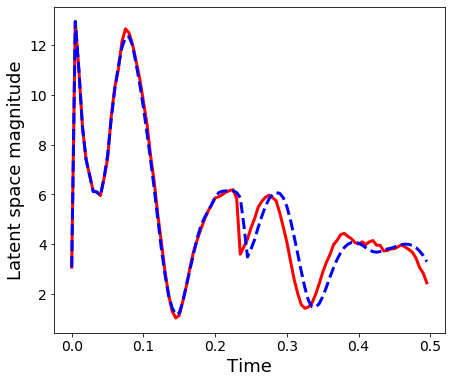

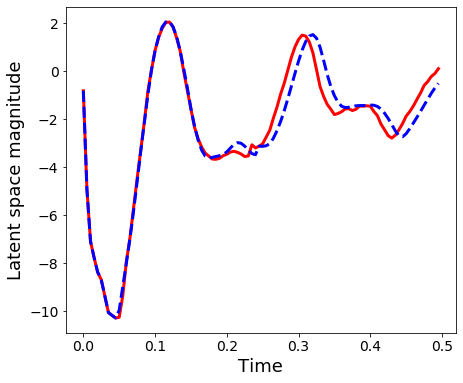

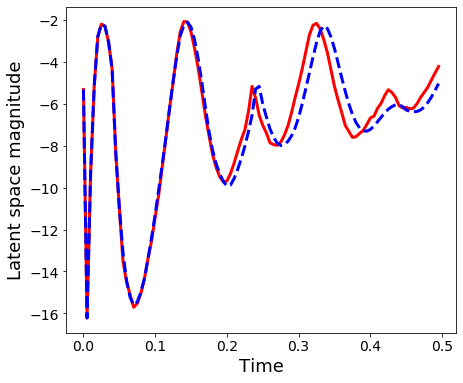

In [21]:
sim_num = 4
for i in range(num_latent):
    plt.figure(figsize=(7,6))
    plt.plot(np.arange(100)*(0.5/100),lstm_testing_data[sim_num,:,i],'r',label='True',linewidth=3)
    plt.plot(np.arange(100)*(0.5/100),output_seq_pred[sim_num,:,i],'b--',label='Predicted',linewidth=3)
    
    if i == 0:
        plt.legend(fontsize=18)
    plt.ylabel('Latent space magnitude',fontsize=18)
    plt.xlabel('Time',fontsize=18)
    plt.tick_params(axis="both",labelsize=14)
    plt.savefig('LSTM_Sim_'+str(sim_num)+'_Mode_'+str(i))
    plt.show()

### Check error metrics in physical space

In [20]:
# Rescale
swe_test_data_phys = unscale(swe_test_data,scaler)

### Check what happens from LSTM based interpolation

In [59]:
start_time = time.time()
cae_test_scaled = np.empty(shape=(1000,64,64,3))
for sim_num in range(10):
    decoded_valid = K.eval(decoder(output_seq_pred[sim_num].astype('float32')))
    cae_test_scaled[100*sim_num:100*(sim_num+1)] = decoded_valid

cae_test_preds = unscale(cae_test_scaled,scaler)
end_time = time.time()
print('Average time for reconstruction:',(end_time-start_time)/10.0)

# Error calculation (except initial condition)
q1_cae_error = 0
q2_cae_error = 0
q3_cae_error = 0

num_fields = 0
for sim_num in range(10):
    for i in range(1,100):
        q1_cae_error+= np.mean((cae_test_preds[sim_num*100+i,:,:,0]-swe_test_data_phys[sim_num*100+i,:,:,0])**2)
        q2_cae_error+= np.mean((cae_test_preds[sim_num*100+i,:,:,1]-swe_test_data_phys[sim_num*100+i,:,:,1])**2)
        q3_cae_error+= np.mean((cae_test_preds[sim_num*100+i,:,:,2]-swe_test_data_phys[sim_num*100+i,:,:,2])**2)
        
        num_fields+=1
        
q1_cae_error = q1_cae_error/num_fields
q2_cae_error = q2_cae_error/num_fields
q3_cae_error = q3_cae_error/num_fields        

Average time for reconstruction: 0.16657330989837646


### Check comparisons with Galerkin Projection

In [22]:
def gp_loader(num_dof):
    q1_gp_coeffs = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Coefficients_q1_pred.npy')
    q2_gp_coeffs = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Coefficients_q2_pred.npy')
    q3_gp_coeffs = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Coefficients_q3_pred.npy')

    q1_modes = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Vectors_q1.npy')
    q2_modes = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Vectors_q2.npy')
    q3_modes = np.load('../Equation_Based/'+str(num_dof)+'_DOF/PCA_Vectors_q3.npy')

    try:
        q1_gp = np.matmul(q1_modes,q1_gp_coeffs)
        q2_gp = np.matmul(q2_modes,q2_gp_coeffs)
        q3_gp = np.matmul(q3_modes,q3_gp_coeffs)
    except:
        q1_gp = np.matmul(q1_modes[:,:num_dof],q1_gp_coeffs)
        q2_gp = np.matmul(q2_modes[:,:num_dof],q2_gp_coeffs)
        q3_gp = np.matmul(q3_modes[:,:num_dof],q3_gp_coeffs)

    gp_test_data = np.zeros(shape=(np.shape(swe_test_data)[0],64,64,3)) # Channels last
    for i in range(np.shape(swe_test_data)[0]):
        temp_1 = q1_gp[:64*64,i].reshape(64,64).T
        temp_2 = q2_gp[:64*64,i].reshape(64,64).T
        temp_3 = q3_gp[:64*64,i].reshape(64,64).T
        gp_test_data[i,:,:,0] = np.transpose(temp_1[:,:])
        gp_test_data[i,:,:,1] = np.transpose(temp_2[:,:])
        gp_test_data[i,:,:,2] = np.transpose(temp_3[:,:])

    # Error calculation for GP (except initial condition)
    q1_gp_error = 0
    q2_gp_error = 0
    q3_gp_error = 0
    
    num_fields = 0
    for sim_num in range(10):
        for i in range(1,100):
            q1_gp_error+= np.mean((gp_test_data[sim_num*100+i,:,:,0]-swe_test_data_phys[sim_num*100+i,:,:,0])**2)
            q2_gp_error+= np.mean((gp_test_data[sim_num*100+i,:,:,1]-swe_test_data_phys[sim_num*100+i,:,:,1])**2)
            q3_gp_error+= np.mean((gp_test_data[sim_num*100+i,:,:,2]-swe_test_data_phys[sim_num*100+i,:,:,2])**2)
            
            num_fields+=1
            
    q1_gp_error = q1_gp_error/num_fields
    q2_gp_error = q2_gp_error/num_fields
    q3_gp_error = q3_gp_error/num_fields 
            
    return gp_test_data, q1_gp_error, q2_gp_error, q3_gp_error

In [23]:
gp_test_data_4, q1_gp_error_4, q2_gp_error_4, q3_gp_error_4 = gp_loader(4)
gp_test_data_6, q1_gp_error_6, q2_gp_error_6, q3_gp_error_6 = gp_loader(6)
gp_test_data_40, q1_gp_error_40, q2_gp_error_40, q3_gp_error_40 = gp_loader(40)

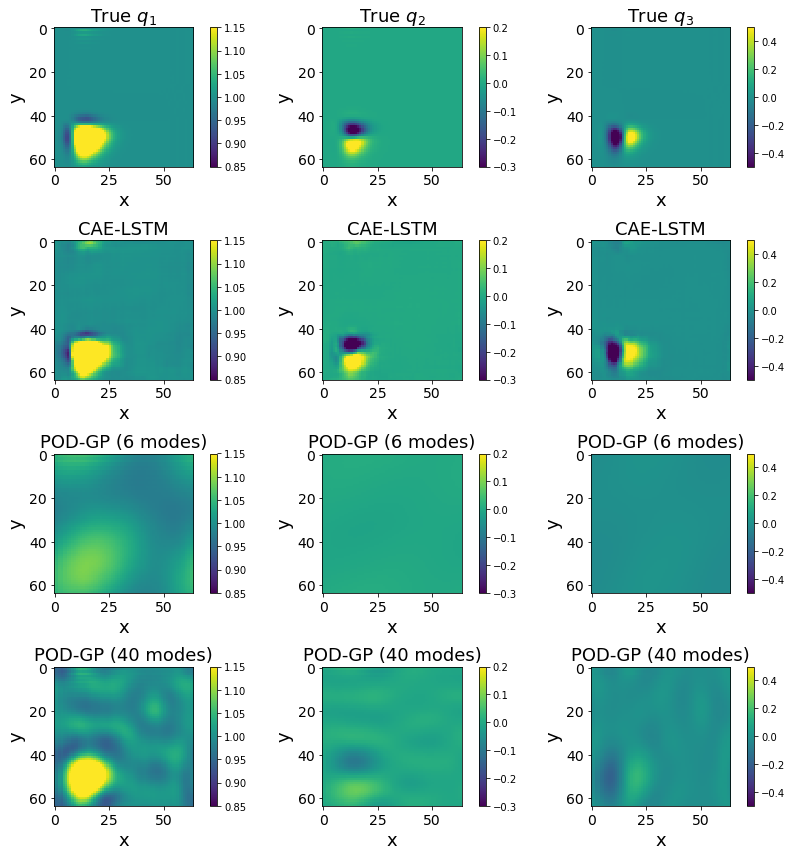

In [49]:
time = 1

fig, ax = plt.subplots(nrows=4,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_test_data_phys[time,:,:,0],label='Truth',vmin=0.85,vmax=1.15)
cs2 = ax[1,0].imshow(cae_test_preds[time,:,:,0],label='CAE-LSTM',vmin=0.85,vmax=1.15)
cs3 = ax[2,0].imshow(gp_test_data_6[time,:,:,0],label='POD-GP 6 modes',vmin=0.85,vmax=1.15)
cs4 = ax[3,0].imshow(gp_test_data_40[time,:,:,0],label='POD-GP 40 modes',vmin=0.85,vmax=1.15)

fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,0],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,0],fraction=0.046, pad=0.04)

cs1 = ax[0,1].imshow(swe_test_data_phys[time,:,:,1],label='Truth',vmin=-0.3,vmax=0.2)
cs2 = ax[1,1].imshow(cae_test_preds[time,:,:,1],label='Prediction',vmin=-0.3,vmax=0.2)
cs3 = ax[2,1].imshow(gp_test_data_6[time,:,:,1],label='POD-GP 6 modes',vmin=-0.3,vmax=0.2)
cs4 = ax[3,1].imshow(gp_test_data_40[time,:,:,1],label='POD-GP 40 modes',vmin=-0.3,vmax=0.2)

fig.colorbar(cs1,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,1],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,1],fraction=0.046, pad=0.04)

cs1 = ax[0,2].imshow(swe_test_data_phys[time,:,:,2],label='Truth',vmin=-0.5,vmax=0.5)
cs2 = ax[1,2].imshow(cae_test_preds[time,:,:,2],label='Prediction',vmin=-0.5,vmax=0.5)
cs3 = ax[2,2].imshow(gp_test_data_6[time,:,:,2],label='POD-GP 6 modes',vmin=-0.5,vmax=0.5)
cs4 = ax[3,2].imshow(gp_test_data_40[time,:,:,2],label='POD-GP 40 modes',vmin=-0.5,vmax=0.5)


fig.colorbar(cs1,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,2],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,2],fraction=0.046, pad=0.04)

for i in range(4):
    for j in range(3):
        ax[i,j].set_xlabel('x',fontsize=18)
        ax[i,j].set_ylabel('y',fontsize=18)
        ax[i,j].tick_params(labelsize=14)
        

ax[0,0].set_title(r'True $q_1$',fontsize=18)
ax[0,1].set_title(r'True $q_2$',fontsize=18)
ax[0,2].set_title(r'True $q_3$',fontsize=18)

ax[1,0].set_title(r'CAE-LSTM',fontsize=18)
ax[1,1].set_title(r'CAE-LSTM',fontsize=18)
ax[1,2].set_title(r'CAE-LSTM',fontsize=18)

ax[2,0].set_title(r'POD-GP (6 modes)',fontsize=18)
ax[2,1].set_title(r'POD-GP (6 modes)',fontsize=18)
ax[2,2].set_title(r'POD-GP (6 modes)',fontsize=18)

ax[3,0].set_title(r'POD-GP (40 modes)',fontsize=18)
ax[3,1].set_title(r'POD-GP (40 modes)',fontsize=18)
ax[3,2].set_title(r'POD-GP (40 modes)',fontsize=18)

plt.subplots_adjust(wspace=-0.5, hspace=0.5)
plt.tight_layout()
plt.savefig('CAE_GP_Comparison_0.png')
plt.show()

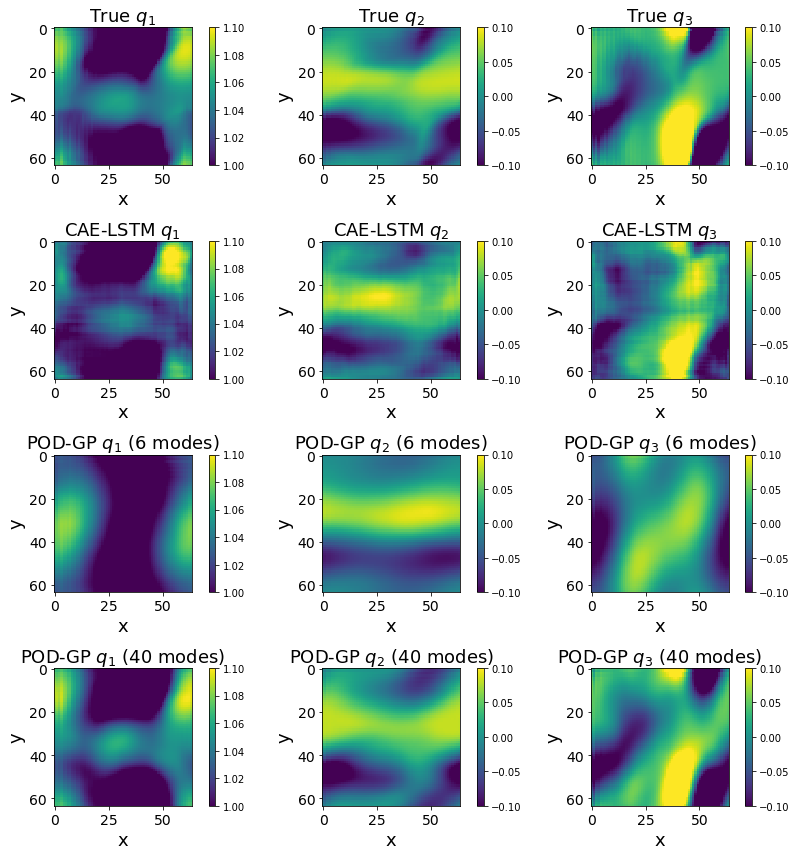

In [53]:
time = 30

fig, ax = plt.subplots(nrows=4,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_test_data_phys[time,:,:,0],label='Truth',vmin=1.0,vmax=1.1)
cs2 = ax[1,0].imshow(cae_test_preds[time,:,:,0],label='CAE-LSTM',vmin=1.0,vmax=1.1)
cs3 = ax[2,0].imshow(gp_test_data_6[time,:,:,0],label='POD-GP 6 modes',vmin=1.0,vmax=1.1)
cs4 = ax[3,0].imshow(gp_test_data_40[time,:,:,0],label='POD-GP 40 modes',vmin=1.0,vmax=1.1)

fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,0],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,0],fraction=0.046, pad=0.04)

cs1 = ax[0,1].imshow(swe_test_data_phys[time,:,:,1],label='Truth',vmin=-0.1,vmax=0.1)
cs2 = ax[1,1].imshow(cae_test_preds[time,:,:,1],label='Prediction',vmin=-0.1,vmax=0.1)
cs3 = ax[2,1].imshow(gp_test_data_6[time,:,:,1],label='POD-GP 6 modes',vmin=-0.1,vmax=0.1)
cs4 = ax[3,1].imshow(gp_test_data_40[time,:,:,1],label='POD-GP 40 modes',vmin=-0.1,vmax=0.1)

fig.colorbar(cs1,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,1],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,1],fraction=0.046, pad=0.04)

cs1 = ax[0,2].imshow(swe_test_data_phys[time,:,:,2],label='Truth',vmin=-0.1,vmax=0.1)
cs2 = ax[1,2].imshow(cae_test_preds[time,:,:,2],label='Prediction',vmin=-0.1,vmax=0.1)
cs3 = ax[2,2].imshow(gp_test_data_6[time,:,:,2],label='POD-GP 6 modes',vmin=-0.1,vmax=0.1)
cs4 = ax[3,2].imshow(gp_test_data_40[time,:,:,2],label='POD-GP 40 modes',vmin=-0.1,vmax=0.1)


fig.colorbar(cs1,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,2],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[3,2],fraction=0.046, pad=0.04)

for i in range(4):
    for j in range(3):
        ax[i,j].set_xlabel('x',fontsize=18)
        ax[i,j].set_ylabel('y',fontsize=18)
        ax[i,j].tick_params(labelsize=14)
        

ax[0,0].set_title(r'True $q_1$',fontsize=18)
ax[0,1].set_title(r'True $q_2$',fontsize=18)
ax[0,2].set_title(r'True $q_3$',fontsize=18)

ax[1,0].set_title(r'CAE-LSTM $q_1$',fontsize=18)
ax[1,1].set_title(r'CAE-LSTM $q_2$',fontsize=18)
ax[1,2].set_title(r'CAE-LSTM $q_3$',fontsize=18)

ax[2,0].set_title(r'POD-GP $q_1$ (6 modes)',fontsize=18)
ax[2,1].set_title(r'POD-GP $q_2$ (6 modes)',fontsize=18)
ax[2,2].set_title(r'POD-GP $q_3$ (6 modes)',fontsize=18)

ax[3,0].set_title(r'POD-GP $q_1$ (40 modes)',fontsize=18)
ax[3,1].set_title(r'POD-GP $q_2$ (40 modes)',fontsize=18)
ax[3,2].set_title(r'POD-GP $q_3$ (40 modes)',fontsize=18)

plt.subplots_adjust(wspace=-0.5, hspace=0.5)
plt.tight_layout()
plt.savefig('CAE_GP_Comparison_1.png')
plt.show()

In [60]:
print('CAE error for $q_1$:',q1_cae_error,'6 mode GP error for $q_1$:',q1_gp_error_6)
print('CAE error for $q_2$:',q2_cae_error,'6 mode GP error for $q_2$:',q2_gp_error_6)
print('CAE error for $q_3$:',q3_cae_error,'6 mode GP error for $q_3$:',q3_gp_error_6)

print('\n')

print('CAE error for $q_1$:',q1_cae_error,'40 mode GP error for $q_1$:',q1_gp_error_40)
print('CAE error for $q_2$:',q2_cae_error,'40 mode GP error for $q_2$:',q2_gp_error_40)
print('CAE error for $q_3$:',q3_cae_error,'40 mode GP error for $q_3$:',q3_gp_error_40)

CAE error for $q_1$: 0.0004835560550926346 6 mode GP error for $q_1$: 0.0005614391985661271
CAE error for $q_2$: 0.00048178734663940003 6 mode GP error for $q_2$: 0.00078030461964863
CAE error for $q_3$: 0.0030459062504156827 6 mode GP error for $q_3$: 0.0033338516871745712


CAE error for $q_1$: 0.0004835560550926346 40 mode GP error for $q_1$: 0.0001729513193407968
CAE error for $q_2$: 0.00048178734663940003 40 mode GP error for $q_2$: 0.0002599963384494518
CAE error for $q_3$: 0.0030459062504156827 40 mode GP error for $q_3$: 0.0011040033019084745


### True 3D plots

In [28]:
def SWE_3D_plotter(time,dataset,var_name):
    x = np.linspace(-1/2, 1/2, 64)  # Array with x-points
    y = np.linspace(-1/2, 1/2, 64)  # Array with x-points

    # Meshgrid for plotting
    X, Y = np.meshgrid(x, y)

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize = (11, 7))
    ax = Axes3D(fig)
    surf = ax.plot_surface(X, Y, dataset[time,:,:,0], rstride = 1, cstride = 1,
        cmap = plt.cm.jet, linewidth = 0, antialiased = True)

    # ax.set_title('Visualization', fontname = "serif", fontsize = 17)
    ax.set_xlabel('x [m]', fontsize = 16)
    ax.set_ylabel('y [m]', fontsize = 16)

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.tick_params(axis='both', which='major', pad=15)
    ax.set_zlim((0.0,2))

    plt.savefig(var_name+'_q1_Time_'+str(time)+'.png')
    plt.close()


    fig = plt.figure(figsize = (11, 7))
    ax = Axes3D(fig)
    surf = ax.plot_surface(X, Y, dataset[time,:,:,1], rstride = 1, cstride = 1,
        cmap = plt.cm.jet, linewidth = 0, antialiased = True)

    # ax.set_title('Visualization', fontname = "serif", fontsize = 17)
    ax.set_xlabel('x [m]', fontsize = 16)
    ax.set_ylabel('y [m]', fontsize = 16)

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.tick_params(axis='both', which='major', pad=15)
    ax.set_zlim((-0.5,0.5))

    plt.savefig(var_name+'_q2_Time_'+str(time)+'.png')
    plt.close()

    fig = plt.figure(figsize = (11, 7))
    ax = Axes3D(fig)
    surf = ax.plot_surface(X, Y, dataset[time,:,:,2], rstride = 1, cstride = 1,
        cmap = plt.cm.jet, linewidth = 0, antialiased = True)

    # ax.set_title('Visualization', fontname = "serif", fontsize = 17)
    ax.set_xlabel('x [m]', fontsize = 16)
    ax.set_ylabel('y [m]', fontsize = 16)

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.xaxis.labelpad=30
    ax.yaxis.labelpad=30

    ax.tick_params(axis='both', which='major', pad=15)
    ax.set_zlim((-0.5,0.5))

    plt.savefig(var_name+'_q3_Time_'+str(time)+'.png')
    plt.close()

In [31]:
time = 1
SWE_3D_plotter(time,swe_test_data_phys,'True')
SWE_3D_plotter(time,cae_test_preds,'CAE')
SWE_3D_plotter(time,gp_test_data_6,'GP_6')
SWE_3D_plotter(time,gp_test_data_40,'GP_40')

In [32]:
time = 5
SWE_3D_plotter(time,swe_test_data_phys,'True')
SWE_3D_plotter(time,cae_test_preds,'CAE')
SWE_3D_plotter(time,gp_test_data_6,'GP_6')
SWE_3D_plotter(time,gp_test_data_40,'GP_40')